### Подключение библиотек

In [3]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans

# Понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from lightgbm import LGBMRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

In [4]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method == 'pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
    
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data=components, columns=colnames)

In [5]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)
    
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                       c=components_with_labels_df.iloc[:, -1],
                                       cmap=plt.get_cmap('jet'),
                                       alpha=0.5, figsize=(15, 10))
    else:
        components_with_labels_df.plot(kind='scatter', cmap=plt.get_cmap('jet'),
                                       alpha=0.5, figsize=(15, 10))
        
    plt.xlabel('Component_1')
    plt.ylabel('Component_2')
    plt.title('2D mapping of object')
    plt.show()

In [6]:
def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   c=components_with_labels_df.iloc[:, -1],
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   alpha=0.5)
        
    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of object')
    plt.show()

In [8]:
def apply_elbow_method(X):
    """Визуализация метода локтя"""
    
    distortions = []
    K = range(2, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        
    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('K')
    plt.ylabel('Distortions')
    plt.title('The elbow method showing for optimal k')
    plt.show()

In [9]:
def display_clusters_distibutions(unique_labels, labels_count):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8, 5))
    
    plt.bar(unique_labels, labels_count)
    
    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    
    plt.title('Cluster distribution')
    plt.show()

In [10]:
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели"""
    
    print( "R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
            "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
            "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3))
          )
    plt.figure(figsize=(10, 10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    
    plt.show()

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Пути к данным

In [11]:
TRAIN_DATASET_PATH='./housing_prepared.csv'
TRAIN_DATASET_EXT_PATH='./housing_train_ext.csv'

### Загрузка данных

In [53]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0


In [54]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

In [55]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.95 MB
Memory usage after optimization is: 0.75 MB
Decreased by 61.5%


In [56]:
df.dtypes

longitude             float32
latitude              float32
housing_median_age    float32
total_rooms           float32
total_bedrooms        float32
population            float32
households            float32
median_income         float32
<1H OCEAN                int8
INLAND                   int8
NEAR BAY                 int8
NEAR OCEAN               int8
median_house_value    float32
dtype: object

In [57]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [58]:
X.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0


In [59]:
X.dtypes

longitude             float32
latitude              float32
housing_median_age    float32
total_rooms           float32
total_bedrooms        float32
population            float32
households            float32
median_income         float32
<1H OCEAN                int8
INLAND                   int8
NEAR BAY                 int8
NEAR OCEAN               int8
dtype: object

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### Масштабирование

In [61]:
# RobustScaler устойчив к выбросам, StandardScaler нет, лучше пользоваться RobustScaler
scalar = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

colnames = X.columns

X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scalar.fit_transform(X_test), columns=colnames)

X_train_scaled.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,0.058201,-0.047493,0.277778,-1.003827,-0.840000,-0.740781,-0.847095,-0.887348,1.0,0.0,0.0,0.0
1,0.142857,-0.039577,0.444444,-0.315573,-0.182857,0.000000,-0.186544,-0.241859,0.0,1.0,0.0,0.0


**Необходимо** применять масштабирование
- во всех методах понижения размерности
- во всех методах линейной регрессии

Масштабирование и нормализацию **можно не использовать**
- дерево решений
- случайный лес
- градиентный бустинг

### Понижение размерности данных

### PCA

In [62]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

,component_1,component_2
0,-2.325676,0.300859
1,-0.968829,-0.096801


In [63]:
dim_reducer2d

PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

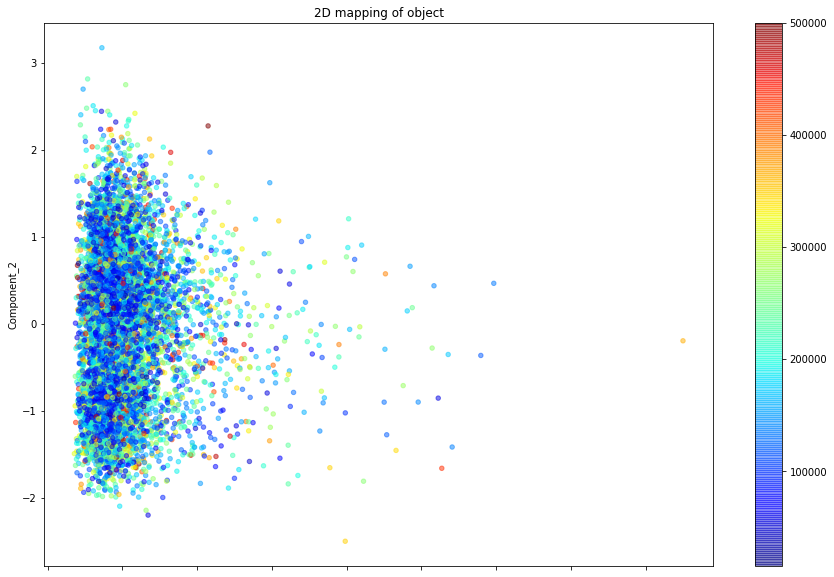

In [26]:
display_components_in_2D_space(components_2d, y_train)

Насколько понизили размерность:

In [28]:
 X_train_scaled.shape[1], components_2d.shape[1]

(12, 2)

Какой процент дисперсии при этом сохранен:

In [40]:
print(np.round(dim_reducer2d.explained_variance_ratio_.sum(), 4)*100, '%')

76.25 %


Понижение до 3-х компонент

In [64]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

In [32]:
dim_reducer3d

PCA(copy=True, iterated_power='auto', n_components=3, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

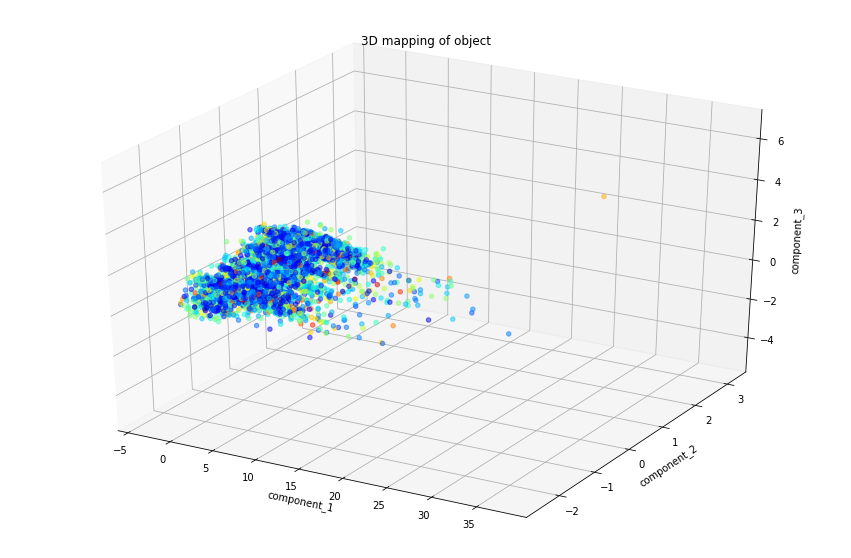

In [33]:
display_components_in_3D_space(components_3d, y_train)

Какую долю дисперсии данных описывают три компоненты:

In [41]:
print(np.round(dim_reducer3d.explained_variance_ratio_.sum(), 4)*100, '%')

83.97 %


Описание около 84% - вполне достаточно, можно оставить по фичам - только 3 компоненты

### Кластеризация k-means

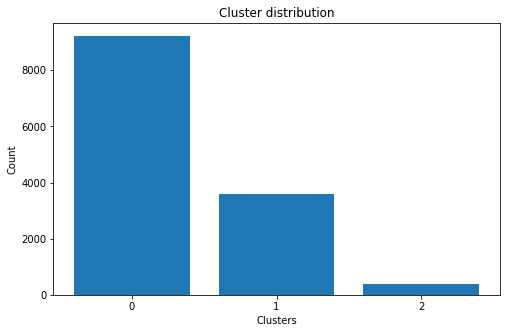

In [65]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast3 = pd.Series(labels_clast3, name='clusters_3')

unique, counts = np.unique(labels_clast3, return_counts=True)
display_clusters_distibutions(unique, counts)

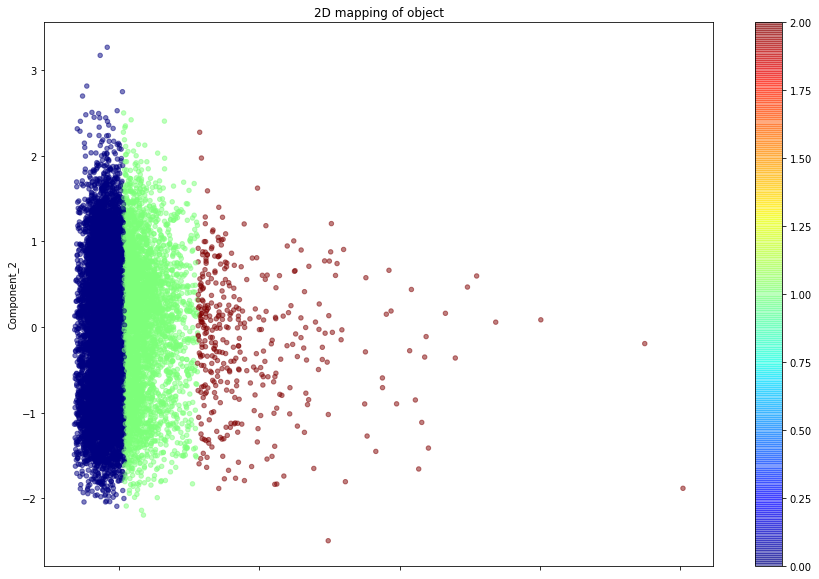

In [43]:
display_components_in_2D_space(components_2d, labels_clast3)

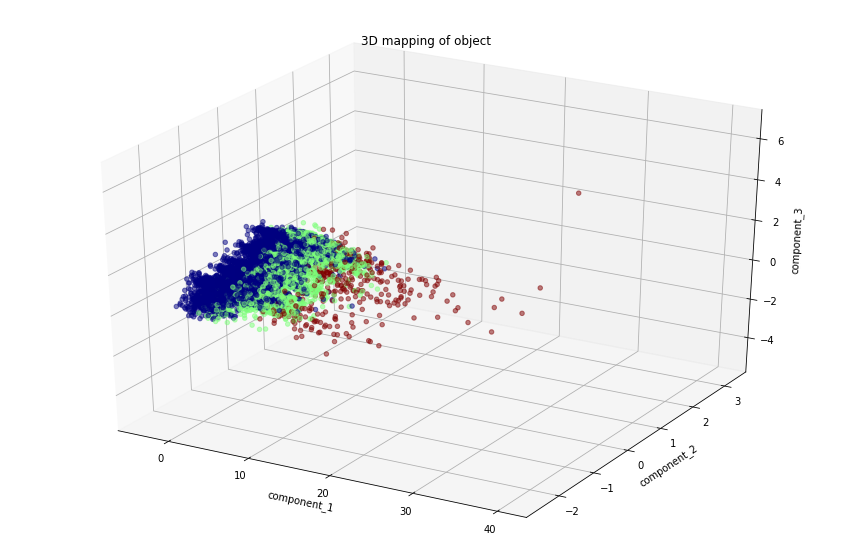

In [44]:
display_components_in_3D_space(components_3d, labels_clast3)

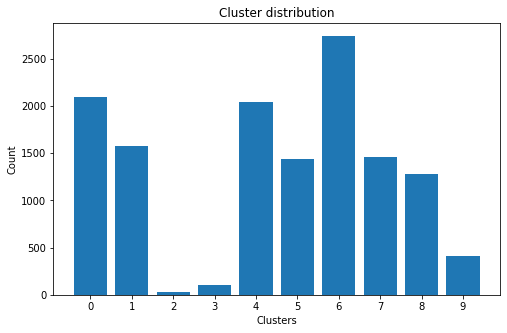

In [66]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast10 = pd.Series(labels_clast10, name='clusters_10')

unique, counts = np.unique(labels_clast10, return_counts=True)
display_clusters_distibutions(unique, counts)

### Оценка оптимального количества кластеров

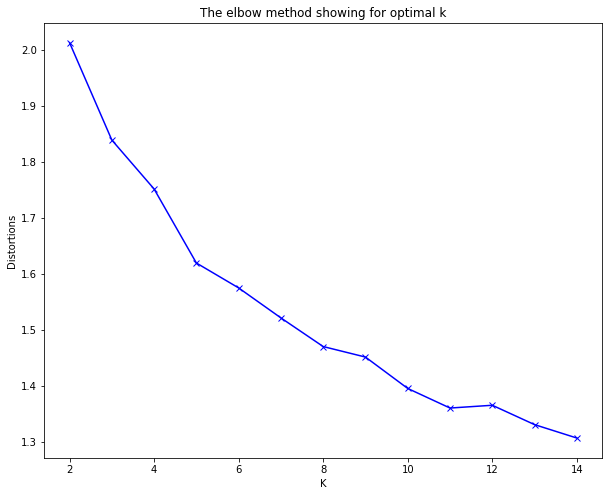

In [47]:
apply_elbow_method(X_train_scaled)

### Добавление кластеризации и главных компонент в датасет

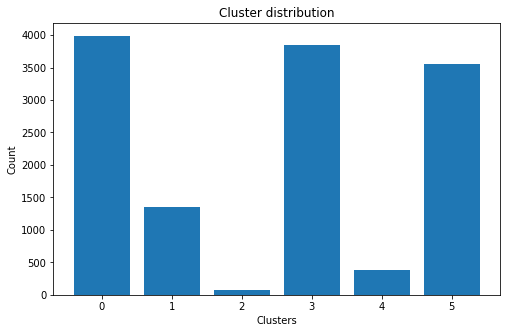

In [48]:
kmeans_6 = KMeans(n_clusters=6, random_state=42)
labels_clast6 = kmeans_6.fit_predict(X_train_scaled)
labels_clast6 = pd.Series(labels_clast6, name='clusters_6')

unique, counts = np.unique(labels_clast6, return_counts=True)
display_clusters_distibutions(unique, counts)

In [76]:
clusters_3_dummy = pd.get_dummies(labels_clast3, drop_first=True, prefix='clusters_3')
clusters_10_dummy = pd.get_dummies(labels_clast10, drop_first=True, prefix='clusters_10')

X_train_scaled = pd.concat([X_train_scaled, components_3d, clusters_3_dummy, clusters_10_dummy, df['median_house_value']], 
                   axis=1)

In [68]:
X_train_scaled.to_csv(TRAIN_DATASET_EXT_PATH, index=False, encoding='utf-8')

In [79]:
final_model = LGBMRegressor(criterion='mse',
                           max_depth=10,
                           min_samples_leaf=10,
                           random_state=42,
                           n_estimators=400)
final_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              criterion='mse', importance_type='split', learning_rate=0.1,
              max_depth=10, min_child_samples=20, min_child_weight=0.001,
              min_samples_leaf=10, min_split_gain=0.0, n_estimators=400,
              n_jobs=-1, num_leaves=31, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

R2:	0.927
MSE:	685852835.411
RMSE:	26188.792


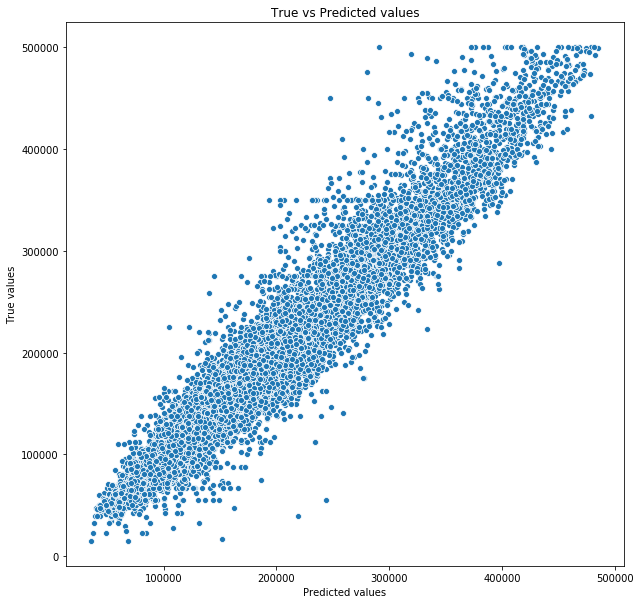

In [80]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.806
MSE:	1897909798.231
RMSE:	43565.007


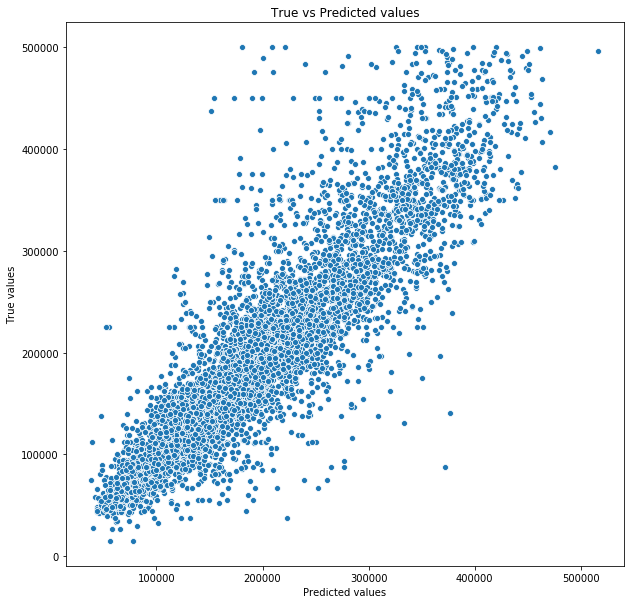

In [81]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [82]:
feature_importance = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_),
                                 columns=['feature_name', 'importance'])
feature_importance.sort_values(by='importance', ascending=False)

,feature_name,importance
1,latitude,2053
0,longitude,2038
7,median_income,1697
5,population,1416
2,housing_median_age,1175
3,total_rooms,1149
4,total_bedrooms,1043
6,households,996
9,INLAND,165
8,<1H OCEAN,138
